# A short demo to show how B converges to the data-specific pseudoinverse of W

In [7]:
import torch
import torchvision
import numpy as np
from scipy import spatial
import timeit
import matplotlib.pyplot as plt

Here we will show how gradient descent on the energy E = 1/2 ||r - B W r||^2 + alpha/2 ||B||^2 (with Tikhonov regularization of B) aligns B with the data-specific pseudoinverse of W. In this demo, we keep W fixed and assume only one data vector r.

In [2]:
# define the update rule for B
def update_B(r, W, B):
    grad_B = np.outer((- r + B @ W @ r), (W @ r).T)
    return grad_B

# define the data-specific pseudoinverse of W given the data vector r
def ds_pinv(r, W):
    gen_pseudo = np.outer(r,r.T) @ W.T / np.linalg.norm(W @ r)**2
    return gen_pseudo

# define the mismatch energy
def mismatch_energy(r, W, B):
    return .5 * np.linalg.norm(r - B @ W @ r)**2

# define the mismatch energy with regularizer
def mismatch_energy_reg(r, W, B, alpha):
    return .5 * np.linalg.norm(r - B @ W @ r)**2 + alpha/2. * np.linalg.norm(r.T @ B)**2

# Calculate the cosine similarity between two tensors
# using the Frobenius inner product
def cosine_similarity_tensors(A, B):
    product = np.trace(A.T @ B)
    norm = (np.trace(A.T @ A))**.5 * (np.trace(B.T @ B))**.5

    # returns cos(theta)
    return product / norm

# Calculate the cosine similarity between two tensors
# using the Frobenius inner product
def cosine_similarity_vectors(A, B):
    product = A.T @ B
    norm = (A.T @ A)**.5 * (B.T @ B)**.5

    # returns cos(theta)
    return product / norm

# alternative measure for the distance of two tensors
def norm_distance(A,B):
    return np.linalg.norm(A - B)**2 / np.linalg.norm(A) / np.linalg.norm(B)

We are now ready to define our 'net', which here just means the matrices W and B. We do so for several examples: a small test net, and some larger nets.

# Test: small net with 3 -> 2

In [329]:
# define parameters of net
layers = [3, 2]
steps = 5000
bw_lr = 1e-3
alpha = 1e-1
alpha_decay = 0

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * r.T @ B )
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy_reg(r, W, B, alpha))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-5:
            print("reached precision of 10^-5")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 0.10427820329795016
mm energy after 100 steps: 0.09914162604077317
mm energy after 150 steps: 0.09432334356855632
mm energy after 200 steps: 0.08980465973500583
mm energy after 250 steps: 0.08556795126799133
mm energy after 300 steps: 0.08159660676486932
mm energy after 350 steps: 0.07787496914856057
mm energy after 400 steps: 0.07438828138784258
mm energy after 450 steps: 0.0711226352965105
mm energy after 500 steps: 0.06806492323661412
mm energy after 550 steps: 0.06520279256092679
mm energy after 600 steps: 0.06252460263918619
mm energy after 650 steps: 0.06001938432148976
mm energy after 700 steps: 0.057676801700570254
mm energy after 750 steps: 0.05548711604254071
mm energy after 800 steps: 0.05344115176311373
mm energy after 850 steps: 0.05153026433329244
mm energy after 900 steps: 0.049746310005124236
mm energy after 950 steps: 0.048081617254326026
plateau detected, reducing alpha to 0.0
mm energy after 1000 steps: 0.01828401821349037
mm energy after 10

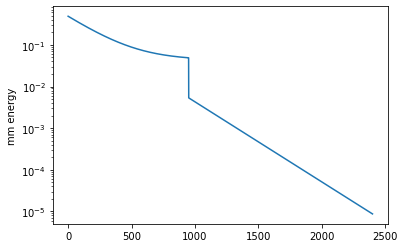

In [77]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

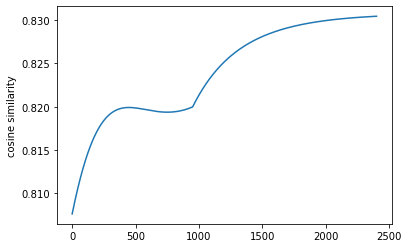

In [78]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

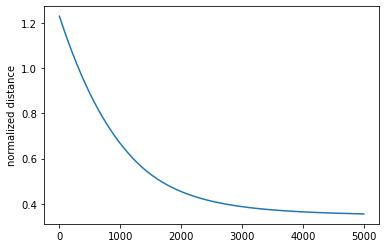

In [9]:
norm_dist = [norm_distance(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(norm_dist)
plt.ylabel('normalized distance')
plt.show()

# A larger net with 100 -> 10

In [20]:
# define parameters of net
layers = [100, 100]
steps = 25000
bw_lr = 1e-5
alpha = 1e+2
alpha_decay = 0

# after how many steps to eval model
per_steps = 1000

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy(r, W, B))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        print(np.linalg.norm(B))
#         if np.isnan(mm_energy[-1]) or np.isinf(mm_energy[-1]):
#             raise ValueError('mm energy inf or nan')
#         print(f'mm energy after {i} steps: {mm_energy[-1]}')
#         if mm_energy[-1] < 1e-5:
#             print("reached precision of 10^-5")
#             break
#         if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
#             alpha *= alpha_decay
#             print(f'plateau detected, reducing alpha to {alpha}')

10.5592918432072
3.8826644915151647
1.4278043786419032
0.5254494897027375
0.19443119124248384
0.07474088992000555
0.03507742520856846
0.02532835016788263
0.023704557095062553
0.023476403138217007
0.023445386361357286
0.02344118974600614
0.023440622306267277
0.023440545587402797
0.02344053521499877
0.02344053381265017
0.023440533623052737
0.023440533597419176
0.023440533593953525
0.02344053359348497
0.023440533593421613
0.023440533593413054
0.023440533593411896
0.02344053359341174


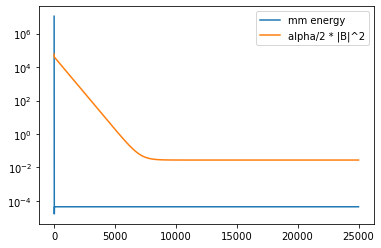

In [21]:
import matplotlib.pyplot as plt
plt.plot(mm_energy, label="mm energy")
B_norm2 = [alpha/2. * np.linalg.norm(B_mat)**2 for B_mat in B_array]
    
plt.plot(B_norm2, label="alpha/2 * |B|^2")
plt.yscale('log')
plt.legend()
plt.show()

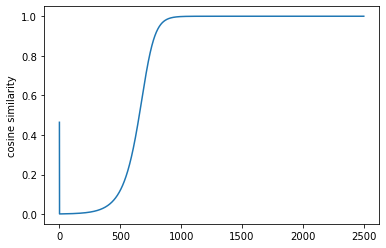

In [23]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array[::10]]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

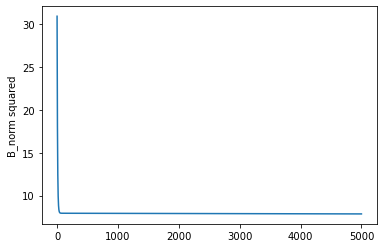

In [190]:
B_norm2 = [alpha * np.linalg.norm(B_mat)**2 for B_mat in B_array]
B_norm2 = [alpha * np.linalg.norm(B_mat)**2 for B_mat in B_array]
    
plt.plot(B_norm2)
plt.ylabel('B_norm squared')
plt.show()

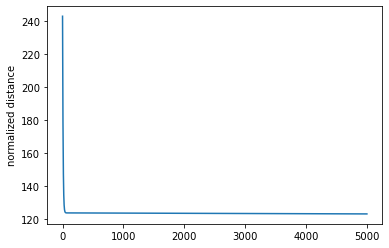

In [183]:
norm_dist = [norm_distance(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(norm_dist)
plt.ylabel('normalized distance')
plt.show()

# The inverse: 10 -> 100

In [22]:
# define parameters of net
layers = [10, 100]
steps = 5000
bw_lr = 1e-3
alpha = 1e+2
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy_reg(r, W, B, alpha))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        if np.isnan(mm_energy[-1]) or np.isinf(mm_energy[-1]):
            raise ValueError('mm energy inf or nan')
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-5:
            print("reached precision of 10^-5")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 0.316592322478641
mm energy after 100 steps: 0.22145678725112222
mm energy after 150 steps: 0.22145426031822274
plateau detected, reducing alpha to 10.0
mm energy after 200 steps: 0.027457148842320866
mm energy after 250 steps: 0.027457148840763335
plateau detected, reducing alpha to 1.0
mm energy after 300 steps: 0.002813191080863946
mm energy after 350 steps: 0.0028131910808562
plateau detected, reducing alpha to 0.1
mm energy after 400 steps: 0.0002820121555617464
plateau detected, reducing alpha to 0.010000000000000002
mm energy after 450 steps: 2.8208164816594727e-05
plateau detected, reducing alpha to 0.0010000000000000002
mm energy after 500 steps: 2.820885993100717e-06
reached precision of 10^-5


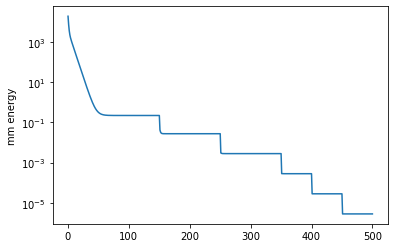

In [23]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

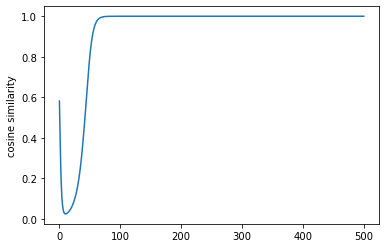

In [24]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

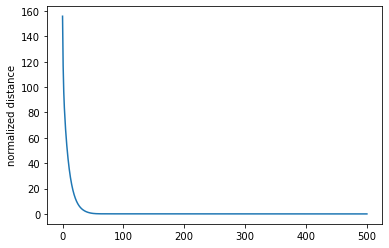

In [25]:
norm_dist = [norm_distance(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(norm_dist)
plt.ylabel('normalized distance')
plt.show()

# A realistic net with 784 -> 500

In [26]:
# define parameters of net
layers = [784, 500]
steps = 5000
bw_lr = 1e-8
alpha = 1e+7
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy_reg(r, W, B, alpha))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        if np.isnan(mm_energy[-1]) or np.isinf(mm_energy[-1]):
            raise ValueError('mm energy inf or nan')
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-5:
            print("reached precision of 10^-5")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 3511855.9939269
mm energy after 100 steps: 138.43718440920824
mm energy after 150 steps: 45.16105363880102
mm energy after 200 steps: 45.15857609428495
plateau detected, reducing alpha to 1000000.0
mm energy after 250 steps: 6.570844778520834
mm energy after 300 steps: 6.570844773748826
plateau detected, reducing alpha to 100000.0
mm energy after 350 steps: 0.6884113393673391
mm energy after 400 steps: 0.6884113391401078
plateau detected, reducing alpha to 10000.0
mm energy after 450 steps: 0.06917091001269426
plateau detected, reducing alpha to 1000.0
mm energy after 500 steps: 0.006920406147643285
plateau detected, reducing alpha to 100.0
mm energy after 550 steps: 0.0006920737837061598
plateau detected, reducing alpha to 10.0
mm energy after 600 steps: 6.920771007752174e-05
plateau detected, reducing alpha to 1.0
mm energy after 650 steps: 6.920774324838716e-06
reached precision of 10^-5


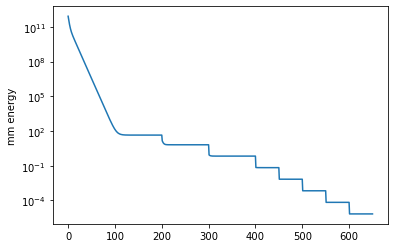

In [27]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

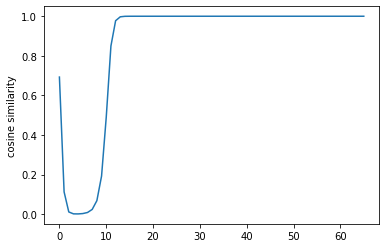

In [29]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array[::10]]

plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

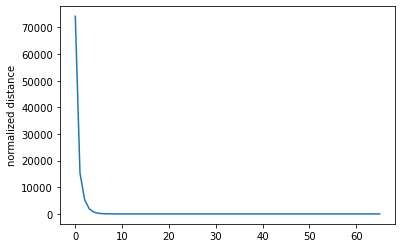

In [30]:
norm_dist = [norm_distance(B_mat, ds_pinv(r, W)) for B_mat in B_array[::10]]
    
plt.plot(norm_dist)
plt.ylabel('normalized distance')
plt.show()

0.1427234041404782
0.1427232932014672


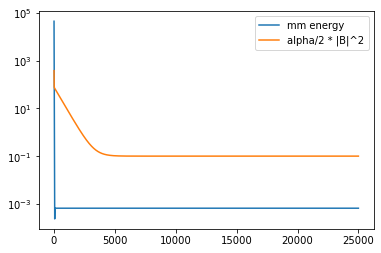

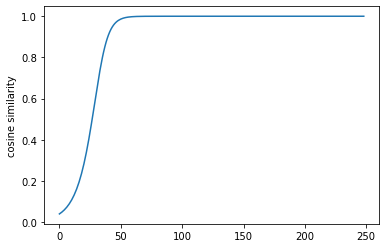

In [78]:
# define parameters of net
layers = [100, 3]
steps = 25000
bw_lr = 1e-4
alpha = 10
alpha_decay = 0

# after how many steps to eval model
per_steps = 10000

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy(r, W, B))
    
    if i % per_steps == 0 and i != 0:
        print(np.linalg.norm(B))
    
plt.plot(mm_energy, label="mm energy")
B_norm2 = [alpha/2. * np.linalg.norm(B_mat)**2 for B_mat in B_array]
    
plt.plot(B_norm2, label="alpha/2 * |B|^2")
plt.yscale('log')
plt.legend()
plt.show()

cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array[100::100]]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

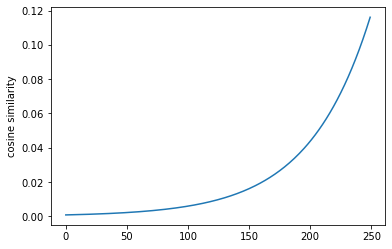

In [53]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array[100::1000]]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

In [67]:
# define parameters of net
layers = [3, 1000]
steps = 1000
bw_lr = 1e-5

alpha = 1e-1

# after how many steps to eval model
per_steps = 10000

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# alpha = 1e-1/np.mean(ds_pinv(r, W))
# print('alpha:', alpha)

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * update_B(r, W, B) + alpha * B
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy(r, W, B))
    
    if i % per_steps == 0 and i != 0:
        print('steps:', i, ' distribution of B:', np.round(np.mean(B),4) , '+-', np.round(np.std(B),4) )

In [71]:
np.mean(ds_pinv(r, W))

0.0005852858592163004

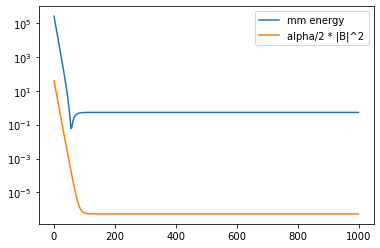

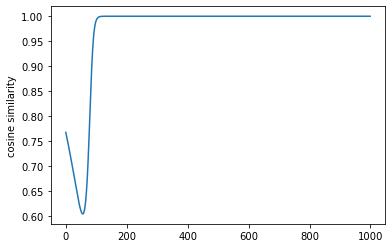

In [68]:
plt.plot(mm_energy, label="mm energy")
B_norm2 = [alpha/2. * np.linalg.norm(B_mat)**2 for B_mat in B_array]
    
plt.plot(B_norm2, label="alpha/2 * |B|^2")
plt.yscale('log')
plt.legend()
plt.show()

cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

In [253]:
layers = [20, 3]

# init weights
W = np.random.uniform(-1, 1, (layers[1],layers[0]))
B = np.random.uniform(-1, 1, (layers[0],layers[1]))
r = np.random.uniform(-1, 1, layers[0])

print(1/(layers[0] * layers[1]**2))
print(np.mean(ds_pinv(r, W)) , '+-', np.std(ds_pinv(r, W)) )

layers = [3, 20]

# init weights
W = np.random.uniform(-1, 1, (layers[1],layers[0]))
B = np.random.uniform(-1, 1, (layers[0],layers[1]))
r = np.random.uniform(-1, 1, layers[0])

print(1/(layers[0] * layers[1]**2))
print(np.mean(ds_pinv(r, W)) , '+-', np.std(ds_pinv(r, W)) )

layers = [20, 20]

# init weights
W = np.random.uniform(-1, 1, (layers[1],layers[0]))
B = np.random.uniform(-1, 1, (layers[0],layers[1]))
r = np.random.uniform(-1, 1, layers[0])

print(1/(layers[0] * layers[1]**2))
print(np.mean(ds_pinv(r, W)) , '+-', np.std(ds_pinv(r, W)) )

0.005555555555555556
-0.004880380429934109 +- 0.255417745540638
0.0008333333333333334
-0.0013503305859578789 +- 0.04751855194731107
0.000125
-0.0003929511163737075 +- 0.018971690157337462


In [288]:
# define parameters of net
layers = [100, 3]
steps = 100000
bw_lr = 1e-4

alpha = 10

# after how many steps to eval model
per_steps = 10000

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# alpha = 1e-1/np.mean(ds_pinv(r, W))
# print('alpha:', alpha)

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy(r, W, B))
    
    if i % per_steps == 0 and i != 0:
        print('steps:', i, ' distribution of B:', np.round(np.mean(B),4) , '+-', np.round(np.std(B),4) )

steps: 10000  distribution of B: 0.0063 +- 0.0034
steps: 20000  distribution of B: 0.0063 +- 0.0034
steps: 30000  distribution of B: 0.0063 +- 0.0034
steps: 40000  distribution of B: 0.0063 +- 0.0034
steps: 50000  distribution of B: 0.0063 +- 0.0034
steps: 60000  distribution of B: 0.0063 +- 0.0034
steps: 70000  distribution of B: 0.0063 +- 0.0034
steps: 80000  distribution of B: 0.0063 +- 0.0034
steps: 90000  distribution of B: 0.0063 +- 0.0034


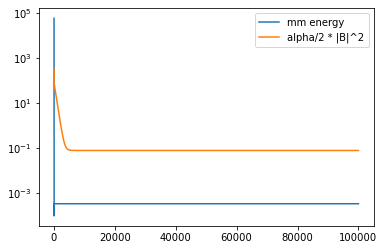

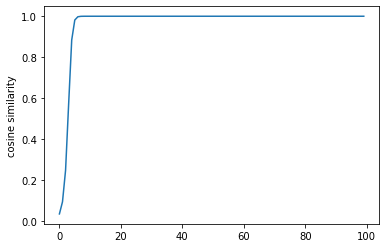

In [289]:
plt.plot(mm_energy, label="mm energy")
B_norm2 = [alpha/2. * np.linalg.norm(B_mat)**2 for B_mat in B_array]
    
plt.plot(B_norm2, label="alpha/2 * |B|^2")
plt.yscale('log')
plt.legend()
plt.show()

cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array[100::1000]]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()